In [1]:
import librosa
import numpy as np

def process_audio(file_path, target_sr=22050):
    # Загрузить аудио файл, конвертируя его в моно
    y, sr = librosa.load(file_path, sr=target_sr, mono=True)
    # Нормализация громкости: приводим амплитуду к диапазону [-1, 1]
    y = y / np.max(np.abs(y))
    return y

In [2]:
import soundfile as sf
from IPython.display import Audio, display
import uuid 

def save_and_display_audio(audio_vector, sample_rate=22050):
    output_path = f'/tmp/{uuid.uuid4().hex}.wav'
    sf.write(output_path, audio_vector, sample_rate)
    # Воспроизвести аудио файл в Jupyter Notebook
    display(Audio(output_path, autoplay=True))

In [3]:
import os
import pandas as pd
import librosa

data_path = './../dataset/jvs_ver1/'
audio_vectors = []
phrases = []

def load_data():
    data = []
    for speaker in os.listdir(data_path):
        speaker_dir = os.path.join(data_path, speaker)
        if not os.path.isdir(speaker_dir):
            continue
        
        for subfolder in ['nonpara30', 'parallel100']:
            wav_path = os.path.join(speaker_dir, subfolder, 'wav24kHz16bit')
            transcripts_path = os.path.join(speaker_dir, subfolder, 'transcripts_utf8.txt')
            
            if not os.path.isdir(wav_path) or not os.path.exists(transcripts_path):
                continue
            
            with open(transcripts_path, 'r', encoding='utf-8') as f:
                transcripts = f.readlines()
            
            for line in transcripts:
                file_name, text = line.strip().split(':')
                audio_path = os.path.join(wav_path, f'{file_name}.wav')
            
                if os.path.exists(audio_path):
                    audio_vec = process_audio(audio_path)
                    audio_vectors.append(audio_vec)
                    phrases.append((text, audio_vec))

In [4]:
load_data()

In [83]:
import whisper_timestamped as whisper
from collections import defaultdict
import numpy as np
import re
from tqdm import tqdm

def recognize_words(audio_vectors, sample_rate=22050):
    model = whisper.load_model("base")
    word_to_audio_map = defaultdict(list)

    for audio_vector in tqdm(audio_vectors, desc="Processing audio files"):
        # Распознаем текст из аудио вектора
        result = model.transcribe(audio_vector, language='ja', word_timestamps=True)
        
        # Получаем временные метки для слов
        segments = result["segments"]
        
        # Проходим по каждому сегменту и нарезаем аудио на слова
        for segment in segments:
            for word_info in segment["words"]:
                word = re.sub("[、？。]", '', word_info["word"].lower())
                    
                start_time = word_info["start"] 
                end_time = word_info["end"]

                #print(start_time, end_time, start_time * 22050, end_time*22050, len(audio_vector))
                
                # Вычисляем индексы для нарезки массива
                start_index = int(start_time * sample_rate)
                end_index = round(end_time * sample_rate)
                
                # Выделяем фрагмент аудио
                word_audio_fragment = audio_vector[start_index:end_index]
                
                if len(word_audio_fragment)/(1.0*sample_rate) < 0.3:
                    continue
                
                amplitude = np.abs(word_audio_fragment)
                amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)
                silence = amplitude_db < -40
                total_samples = len(silence)
                silence_samples = np.sum(silence)
                silence_percentage = (silence_samples / total_samples) * 100

                if silence_percentage > 60:
                    continue
    

                # Добавляем фрагмент в мапу
                word_to_audio_map[word].append(word_audio_fragment)
    
    return dict(word_to_audio_map)

In [84]:
word_to_pronounces = recognize_words(audio_vectors)

Processing audio files: 100%|██████████████████████████████████████████████████████| 12997/12997 [1:02:03<00:00,  3.49it/s]


In [85]:
[k for k in word_to_pronounces]

['何',
 '検',
 '米',
 '国',
 '官',
 '中',
 '50',
 'ド',
 'どう',
 'では',
 'から',
 '内',
 '本',
 'しか',
 'し',
 'で',
 '経',
 'を',
 'に',
 'ので',
 '話',
 'って',
 'この',
 '玉',
 'な',
 '校',
 '生',
 'には',
 'いて',
 '漫',
 'ス',
 'やって',
 '通',
 '肉',
 '彼',
 '金',
 'んで',
 'ル',
 'した',
 '年前',
 '岸',
 'は',
 '一',
 '小',
 '職',
 '策',
 'また',
 '前',
 'ト',
 'こう',
 'ど',
 '鍵',
 'かった',
 'その',
 '入',
 '近',
 '初',
 'めて',
 'する',
 '品',
 'のは',
 '姿',
 '農',
 '習',
 'しく',
 'もう',
 '早',
 'の',
 '東',
 '急',
 'よ',
 'ギ',
 '質',
 '管',
 'ません',
 '当',
 '古',
 '妙',
 'れる',
 '主',
 '王',
 'ニ',
 '牛',
 '乳',
 'スト',
 '白',
 'あり',
 '界',
 '団',
 '関',
 'サ',
 'ため',
 '大',
 '街',
 'シ',
 '事',
 'メ',
 'ーヒ',
 'ー',
 'お',
 '連',
 '駿',
 '取',
 '時間',
 '量',
 '空',
 '間',
 '液',
 'る',
 'プ',
 'チ',
 '給',
 '料',
 'と',
 '山',
 '球',
 'フ',
 '溢',
 '々',
 'まで',
 '構',
 '成',
 'タ',
 'そ',
 'へ',
 '新',
 'しい',
 'して',
 'ク',
 '方',
 '代',
 'が',
 '症',
 '他',
 'べ',
 'セ',
 '問題',
 'ート',
 'ビ',
 '圧',
 '全',
 '会',
 'ベ',
 '転',
 '適',
 '役',
 '上',
 '等',
 'こと',
 'ある',
 '情',
 '南',
 '西',
 'つ',
 '運',
 'エ',
 '表',
 '虐',
 '集',
 '長',


In [90]:
save_and_display_audio(word_to_pronounces['米'][0])

In [146]:
import re

def clean_word(word):
    # Удаляем пунктуацию из слова
    return re.sub(r'[^\w\s]', '', word)

def get_top_keys_by_value_count(word_to_audio_map, top_n=10):
    # Фильтруем слова, длина которых больше одного символа после удаления пунктуации
    filtered_map = {k: v for k, v in word_to_audio_map.items() if len(clean_word(k)) > 2}
    
    # Сортируем ключи словаря по длине списков значений в порядке убывания
    sorted_items = sorted(filtered_map.items(), key=lambda item: len(item[1]), reverse=True)
    
    # Возвращаем топ N ключей вместе с количеством значений
    return [(key, len(values)) for key, values in sorted_items[:top_n]]


In [145]:
get_top_keys_by_value_count(word_to_pronounces)

[('という', 195),
 ('ところ', 116),
 ('ように', 107),
 ('300', 66),
 ('かった', 64),
 ('そして', 40),
 ('100', 31),
 ('ちゃん', 31),
 ('いただ', 31),
 ('ません', 24)]

In [183]:
type(word_to_pronounces)

dict

In [141]:
save_and_display_audio(word_to_pronounces['通'][31])

In [142]:
import pickle
with open('./../dataset/word_to_pronounces.dump', 'rb') as f:
    old = pickle.load(f)

In [191]:
top = get_top_keys_by_value_count(old)

In [195]:
topk = set([k for (k, _) in top])

In [190]:
save_and_display_audio(old['ところ'][6])

In [196]:
import os
import numpy as np
from scipy.io.wavfile import write

# Пример словаря с аудио векторами
audio_dict = {
    'a': [np.random.randn(22050), np.random.randn(22050)],
    'b': [np.random.randn(22050), np.random.randn(22050)]
}

# Частота дискретизации
sample_rate = 22050

# Путь к базовой директории
base_dir = './../dataset/aaa/'

# Создание базовой директории, если она не существует
os.makedirs(base_dir, exist_ok=True)

# Создание папок и сохранение аудио файлов
for key, audio_list in old.items():
    if key not in topk:
        continue
    # Создание папки для текущего ключа внутри базовой директории
    key_dir = os.path.join(base_dir, key)
    os.makedirs(key_dir, exist_ok=True)
    
    # Сохранение каждого аудио вектора как отдельный WAV файл
    for i, audio_vector in enumerate(audio_list):
        file_path = os.path.join(key_dir, f'{key}_{i+1}.wav')
        # Сохранение файла в формате WAV с частотой дискретизации 22050 Гц
        write(file_path, sample_rate, audio_vector.astype(np.float32))


In [206]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

def extract_mfcc_features(file_path, n_mfcc=30, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs


def load_data(data_dir):
    features = []
    labels = []
    
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    mfccs = extract_mfcc_features(file_path)
                    features.append(mfccs)
                    labels.append(label)
                    
    return np.array(features), np.array(labels)

data_dir = './../dataset/aaa/'
X, y = load_data(data_dir)

# Преобразование меток в числовой формат
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

/home/sokket/ML/speak-it-easy/venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [209]:

from tensorflow.keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(30, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,890 (230.04 KB)

 Trainable params: 58,890 (230.04 KB)

 Non-trainable params: 0 (0.00 B)

In [210]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30


I0000 00:00:1721901856.555350 3838906 service.cc:146] XLA service 0x726c98006040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721901856.555420 3838906 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


 1/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1250 - loss: 21.5497

I0000 00:00:1721901857.979079 3838906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1132 - loss: 16.9005 - val_accuracy: 0.3551 - val_loss: 2.0376
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1756 - loss: 5.1017 - val_accuracy: 0.2336 - val_loss: 2.2185
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1806 - loss: 2.6160 - val_accuracy: 0.2009 - val_loss: 2.2430
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1644 - loss: 2.3794 - val_accuracy: 0.3224 - val_loss: 2.1773
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1811 - loss: 2.2957 - val_accuracy: 0.3458 - val_loss: 2.1330
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2348 - loss: 2.1353 - val_accuracy: 0.3131 - val_loss: 2.0918
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1945 - loss: 2.2018 - val_accuracy: 0.3832 - val_loss: 2.0154
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2454 - loss: 2.1188 - val_accuracy: 0.3879 - val_loss: 1.9299
E

In [211]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 1.0686 
Test accuracy: 0.6401869058609009


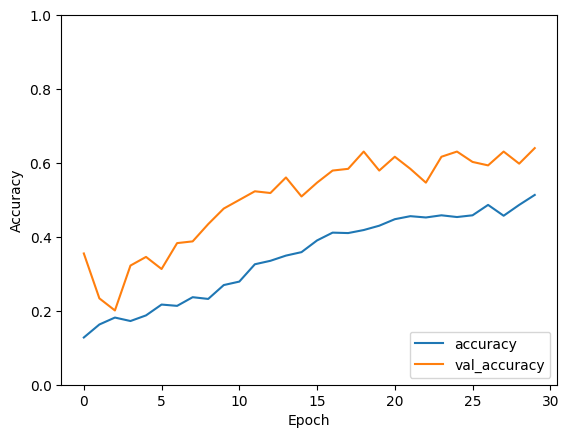

In [213]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()